In [1]:
import polars as pl
from RIG import RuleInstanceGenerator
import pandas as pd

csv_path = "data/data_shucki.csv"
df = pl.read_csv(csv_path)

rig = RuleInstanceGenerator()

def clean_text(text):
    """Remove all non-alphanumeric characters and convert to lowercase."""
    return ''.join(char.lower() for char in text if char.isalnum())

def evaluate_accuracy():
    rag_api = rig.get_instance.classifier.rag_api
    rows = []
    correct_predictions = 0

    # Iterate through the DataFrame rows
    for row in df.iter_rows(named=True):
        # Extract the free_text, actual type_name, and expected classification
        free_text = row['free_text']
        actual_type_name = row['rule_type_names']
        id_free_text = row['id']

        # Predict the type name using the RAG API
        predicted_type_name = str(rag_api.get_closest_type_name(free_text)[0])

        # Clean strings for comparison
        actual_type_name_cleaned = clean_text(actual_type_name)
        predicted_type_name_cleaned = clean_text(predicted_type_name)

        # Debugging: Print the cleaned strings
        # print(f"Actual (cleaned): {actual_type_name_cleaned}")
        # print(f"Predicted (cleaned): {predicted_type_name_cleaned}")

        # Calculate the score (1 for correct, 0 for incorrect)
        score = 1 if predicted_type_name_cleaned == actual_type_name_cleaned else 0
        correct_predictions += score

        # Append the results to the rows
        rows.append({
            "id": id_free_text,
            "score": score,
            "predicted": predicted_type_name_cleaned,
            "actual": actual_type_name_cleaned,
            "free_text": free_text,
        })

    # Convert rows to a DataFrame
    results_df = pl.DataFrame(rows)

    # Calculate the final score
    accuracy = correct_predictions / len(df)

    return results_df, accuracy

# Run the evaluation
results_df, final_score = evaluate_accuracy()

# Print the final accuracy score
print(f"Accuracy Score: {final_score:.2%}")

# Print rows where the prediction was incorrect
errors = results_df.filter(pl.col("score") == 0).to_dicts()
# print("Errors:", errors)

# Optional: Save errors to a CSV
results_df.filter(pl.col("score") == 0).write_csv("output/classification_errors.csv")

print("results_df['actual'].unique():\n")
for i, _ in enumerate(results_df['actual'].unique()):
    print(i, _)

print("results_df['predicted'].unique():\n")
for i, _ in enumerate(results_df['predicted'].unique()):
    print(i, _)

results_df = results_df.to_pandas()


llama_new_context_with_model: n_ctx_per_seq (1024) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn

Accuracy Score: 94.48%
results_df['actual'].unique():

0 satellitedisruption
1 launchfailure
2 equipmentmalfunction
3 disloyalsoldier
4 missilefailure
5 commandincompetence
6 firecontrol
7 defectionthreat
8 leadershipbreakdown
9 bombfailure
10 encryptionflaw
11 platoonreport
12 corruptionscandal
13 betrayalrisk
14 attackoverview
15 supplyshortage
16 covertagent
17 systemfailure
18 missilemalfunction
19 suspectedperson
20 espionagesuspect
results_df['predicted'].unique():

0 bombfailure
1 systemfailure
2 equipmentmalfunction
3 firecontrol
4 suspectedperson
5 corruptionscandal
6 leadershipbreakdown
7 encryptionflaw
8 commandincompetence
9 satellitedisruption
10 platoonreport
11 defectionthreat
12 attackoverview
13 covertagent
14 supplyshortage
15 espionagesuspect
16 missilefailure
17 missilemalfunction
18 betrayalrisk
19 launchfailure
20 disloyalsoldier


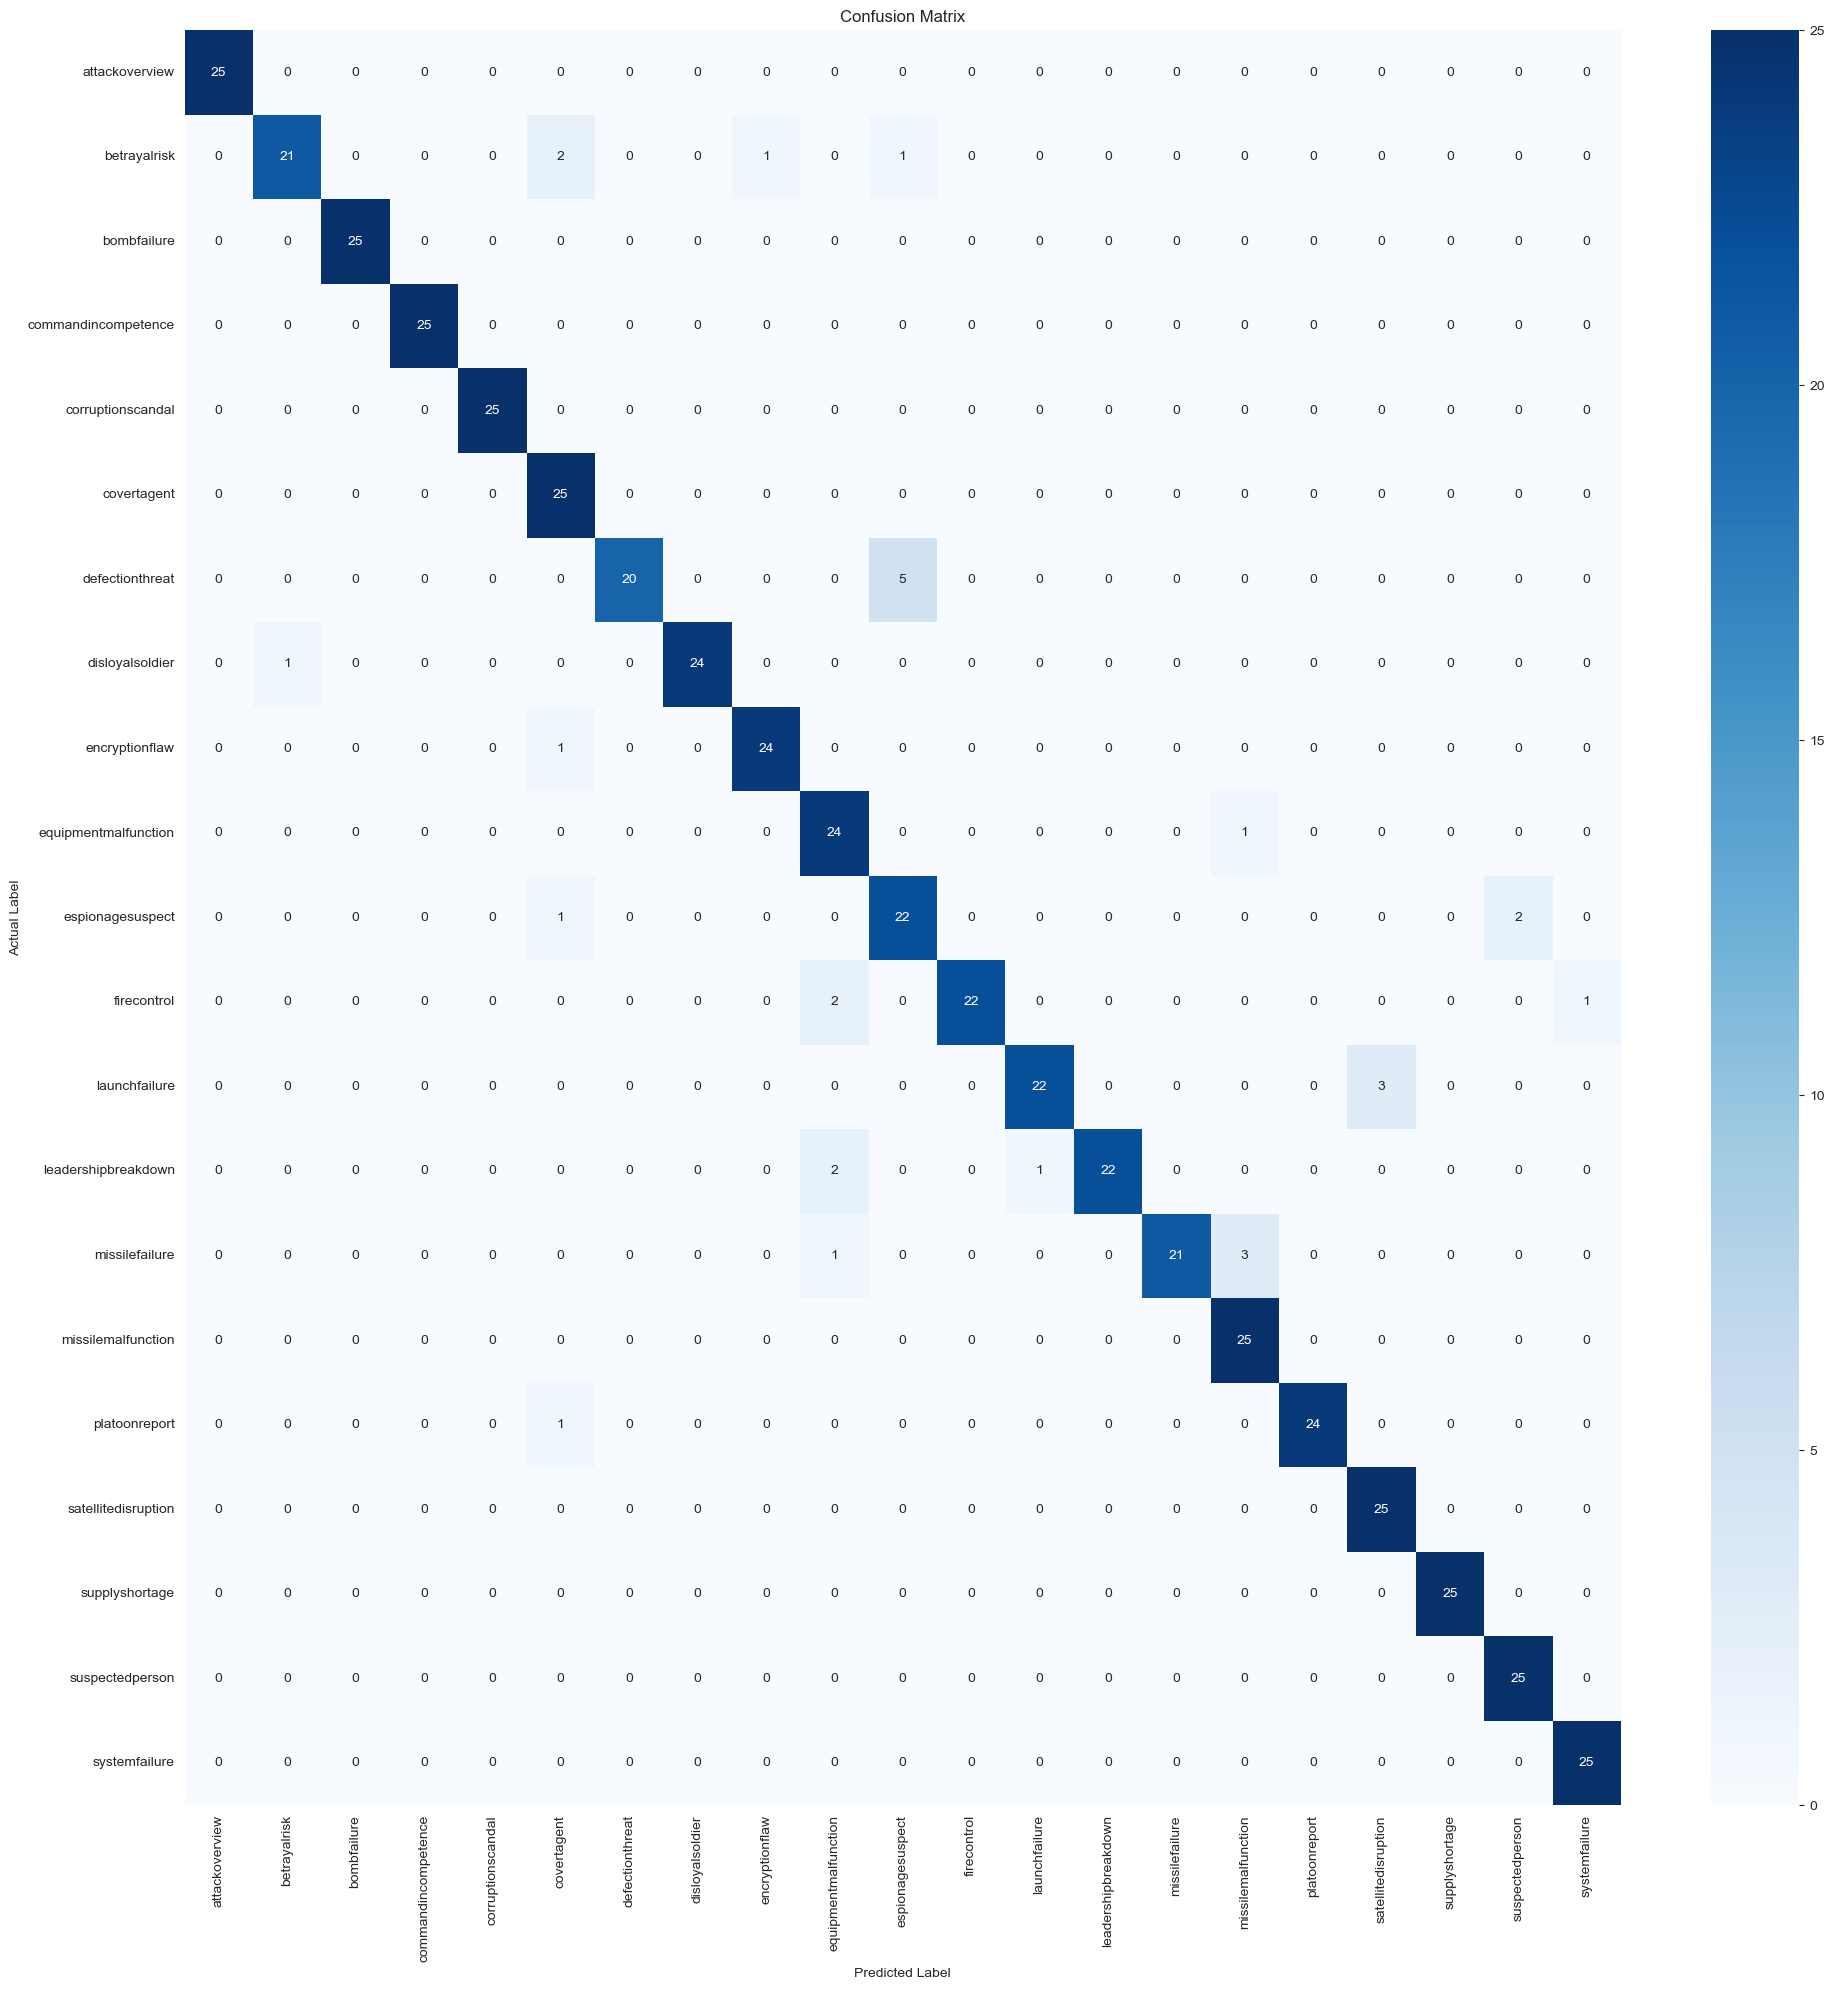

In [2]:

confusion_matrix = pd.crosstab(
    results_df["actual"],
    results_df["predicted"],
    # normalize='index'
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(
    confusion_matrix,
    annot=True,  # Show numbers in each cell
    cmap='Blues',  # Color scheme
    fmt='g',  # Format for the annotations
    xticklabels=confusion_matrix.columns
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()